# Trademark ducky dataset Phase Retrieval

> Georgios Varnavides | Jan 12 2025   
>
> Sample: graphene substrate ducky  
> Sampling conditions: 4 Ang step-sizes  
> Imaging conditions: 20 mrad, 500 A  

In [43]:
# %load_ext autoreload 
# %autoreload 2

In [44]:
import quantem as em
import numpy as np

In [45]:
dataset = em.core.io.load("../data/ducky_20mrad_500A-df_4A-step.zip")
dataset

Dataset(shape=(41, 41, 200, 200), dtype=float32, name='4D-STEM dataset')
  sampling: [4.         4.         1.04392901 1.04392901]
  units: ['A', 'A', 'mrad', 'mrad']
  signal units: 'arb. units'

In [46]:
energy = 80e3
semiangle_cutoff = 20
defocus = 500
rotation_angle = np.deg2rad(-15)

In [47]:
def add_poisson_noise(
    dataset,
    electrons_per_area,
):
    if electrons_per_area == np.inf:
        return dataset
    electrons_per_probe = electrons_per_area * dataset.sampling[:2].prod()
    
    dataset_noisy = dataset.copy()
    dataset_noisy.array = np.random.poisson(dataset.array * electrons_per_probe)
    return dataset_noisy

In [48]:
np.random.seed(2025)
noisy_dataset = add_poisson_noise(
    dataset,
    1e5
)

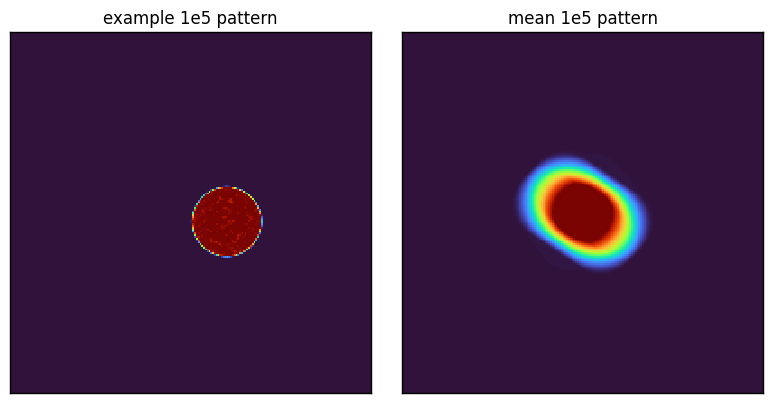

In [49]:
# notice the descan!
em.visualization.show_2d(
    [
        noisy_dataset[0,0].array,
        noisy_dataset.mean((0,1)),
    ],
    title=[
        "example 1e5 pattern","mean 1e5 pattern"
    ],
    power=0.5,
    cmap='turbo'
);

In [50]:
direct_ptycho = em.diffractive_imaging.DirectPtychography.from_dataset4d(
    noisy_dataset,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    rotation_angle=rotation_angle,
    aberration_coefs={"defocus":defocus},
    # device='gpu',
)

100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.66it/s]


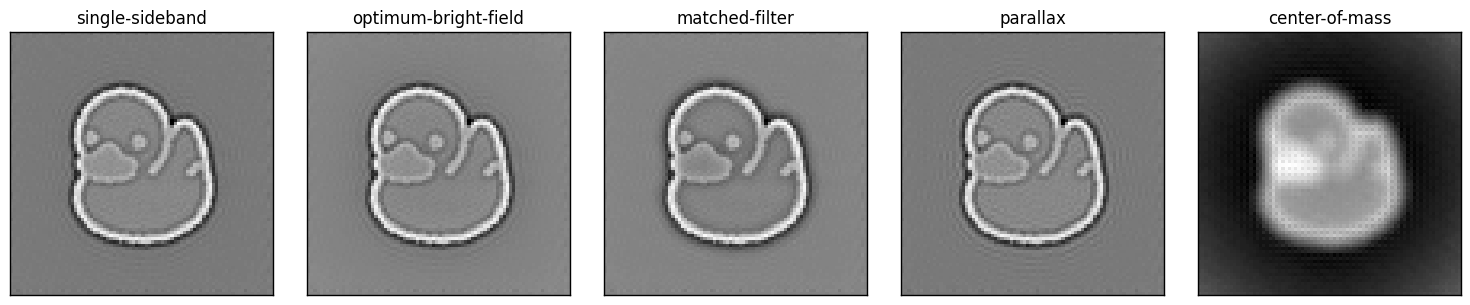

In [51]:
kwargs = {
    "title":["single-sideband","optimum-bright-field","matched-filter","parallax","center-of-mass"],
    "norm":"minmax",
    "axsize":(3,3),
}

recons = direct_ptycho._reconstruct_all_permutations(
    upsampling_factor=2,
)

em.visualization.show_2d(
    recons,
    **kwargs
);

Best trial: 213. Best value: 3.54619e-09: 100%|███████████████████████████| 250/250 [00:40<00:00,  6.11it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': -500.0},
  initial_rotation_angle=np.float64(-0.2617993877991494),
  optimized_aberrations={'C10': -520.165559522203},
  optimized_rotation_angle=-0.26362199466519365,
)


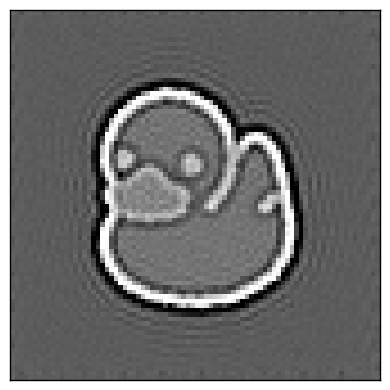

In [63]:
# Optimize defocus with optuna
direct_ptycho = direct_ptycho.optimize_hyperparameters(
    aberration_coefs={
        "C10":em.diffractive_imaging.direct_ptychography.OptimizationParameter(-1000,0),
    },
    rotation_angle=em.diffractive_imaging.direct_ptychography.OptimizationParameter(-0.5,0,0),
    n_trials=250,
    deconvolution_kernel='parallax',
)

em.visualization.show_2d(
    direct_ptycho.reconstruct(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
        verbose=False,
    ).obj
);

Aligning (reference): 100%|███████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': -500.0},
  initial_rotation_angle=np.float64(-0.2617993877991494),
  optimized_aberrations={'C10': -529.3759765625, 'C12': 0.6090204119682312, 'phi12': -0.03858108073472977},
  optimized_rotation_angle=-0.2626831531524658,
)


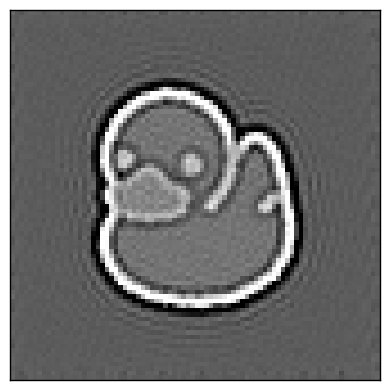

In [62]:
# reference fit from scratch (note the aberration_coeffs and rotation_angle arguments overriding init values)
direct_ptycho = direct_ptycho.fit_hyperparameters_cross_correlation(
    alignment_method='reference',
    bin_factors=(3,2,1,1,1),

    # reset aberrations and rotation to prove it can find it from scratch.
    aberration_coefs = {'C10':0.0,'C12':0.0,'phi12':0.0},
    rotation_angle= 0.0,
)

em.visualization.show_2d(
    direct_ptycho.reconstruct(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
        verbose=False,
    ).obj
);

Fitting aberrations: 100%|████████████████████████████████████████| 4/4 [00:00<00:00,  8.53order/s, ['C10']]


Optimized state:

 HyperparameterState(
  initial_aberrations={'C10': -500.0},
  initial_rotation_angle=np.float64(-0.2617993877991494),
  optimized_aberrations={'C10': -473.2767333984375},
)


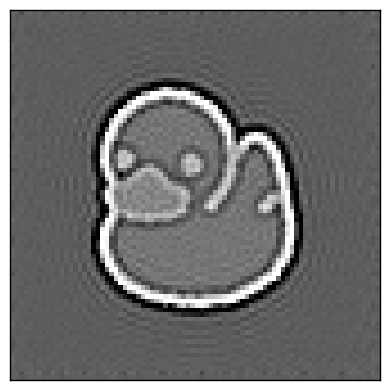

In [78]:
# least-squares fit from scratch (not as good..)
direct_ptycho = direct_ptycho.fit_hyperparameters_least_squares(
    aberration_coefs={"C10":0},
    # cartesian_basis="low_order", # default, ["C10","C12_a","C12_b","C21_a","C21_b","C30"]
    # cartesian_basis=["C10"], # only C10
    cartesian_basis=[["C10"]]*4, # only C10, but recursively refine fit 4 times
    num_q_modes=12,
    q_signal_weight=10.0,
    verbose=True,
)

em.visualization.show_2d(
    direct_ptycho.reconstruct(
        deconvolution_kernel='parallax',
        upsampling_factor=2,
        verbose=False,
    ).obj
);